In [1]:
import json
import csv

# Read JSON from file
with open("generated_data.json", "r") as f:
    data = json.load(f)   # expects a list of dicts with fixed keys

# Write to CSV
with open("output.csv", "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=data[0].keys())
    writer.writeheader()
    writer.writerows(data)

print("Conversion complete: output.csv")


Conversion complete: output.csv


In [2]:
#!/usr/bin/env python3
# Fast synthetic tabular generator for Jupyter use.
# Edits: Replaced argparse with simple variables below (no logic changes).

import numpy as np
import pandas as pd
from pandas.api.types import is_integer_dtype

# ==== Configuration (edit these in your notebook) ====
INPUT_PATH = "input.csv"          # Path to input CSV
OUTPUT_PATH = "synthetic.csv"     # Where to write the synthetic CSV
TARGET_N = 600                    # Target total number of rows
SEED = 42                         # Random seed
JITTER_FRAC = 0.05                # Fraction of std for numeric noise
CAT_FLIP_PROB = 0.05              # Random flip prob for low-cardinality categoricals
# =====================================================

def generate_synthetic(df: pd.DataFrame,
                       target_n: int = 600,
                       jitter_frac: float = 0.05,
                       cat_flip_prob: float = 0.05,
                       seed: int = 42) -> pd.DataFrame:
    """
    Fast synthetic tabular generator:
      - Row bootstrap with replacement until target_n rows are reached
      - Add small Gaussian jitter to numeric columns (scaled by column std)
      - Round & clip integer-like columns to observed [min, max]
      - Randomly flip a small % of low-cardinality categorical columns (<=20 uniques)
    """
    rng = np.random.default_rng(seed)
    np.random.seed(seed)

    n0 = len(df)
    needed = max(target_n - n0, 0)
    if needed == 0:
        return df.sample(n=target_n, replace=False, random_state=seed).reset_index(drop=True)

    # Sample complete rows with replacement
    syn = df.sample(n=needed, replace=True, random_state=seed).reset_index(drop=True)

    # Numeric jitter
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    for col in num_cols:
        s = syn[col]
        base = pd.to_numeric(df[col], errors="coerce")
        std = base.std()
        if pd.isna(std) or std == 0:
            continue  # nothing to jitter

        # noise scale
        scale = max(std * jitter_frac, 1e-12)
        noise = np.random.normal(0.0, scale, size=len(s))
        s_noisy = pd.to_numeric(s, errors="coerce") + noise

        # clip to observed range
        col_min = base.min()
        col_max = base.max()
        s_noisy = np.clip(s_noisy, col_min, col_max)

        # restore integer-like columns
        if is_integer_dtype(df[col].dtype) or np.allclose(base.dropna(), np.round(base.dropna())):
            s_noisy = np.round(s_noisy)
            # Cast carefully to preserve missing values
            if s.isna().any():
                syn[col] = pd.Series(s_noisy, index=s.index).astype("Int64")
            else:
                syn[col] = pd.Series(s_noisy, index=s.index).astype(np.int64)
        else:
            syn[col] = pd.Series(s_noisy, index=s.index).astype(float)

        # Preserve original NaNs
        syn.loc[s.isna(), col] = np.nan

    # Categorical flips for low-cardinality columns
    non_num_cols = [c for c in df.columns if c not in num_cols]
    for col in non_num_cols:
        # Work only on columns with modest cardinality to avoid corrupting free text
        uniq = pd.unique(df[col].dropna())
        if 2 <= len(uniq) <= 20:
            mask = rng.random(len(syn)) < cat_flip_prob
            if mask.any():
                syn.loc[mask, col] = rng.choice(uniq, size=mask.sum(), replace=True)

    out = pd.concat([df, syn], ignore_index=True)

    # Ensure exact target size
    if len(out) > target_n:
        out = out.sample(n=target_n, random_state=seed).reset_index(drop=True)

    return out

# ==== Run ====
df = pd.read_csv(INPUT_PATH)
out = generate_synthetic(
    df,
    target_n=TARGET_N,
    jitter_frac=JITTER_FRAC,
    cat_flip_prob=CAT_FLIP_PROB,
    seed=SEED,
)
out.to_csv(OUTPUT_PATH, index=False)
print(f"Wrote {len(out)} rows to {OUTPUT_PATH}")


Wrote 600 rows to synthetic.csv


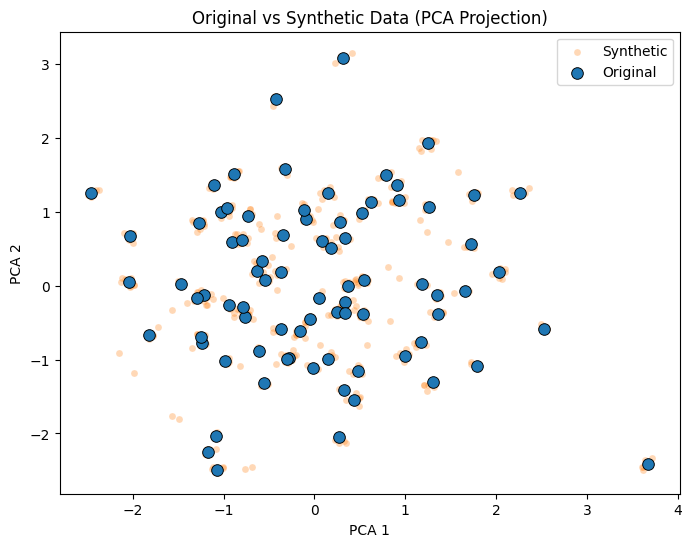

In [7]:
# ============================================
# Visualize synthetic vs. original clusters
# (with original samples plotted on top)
# ============================================
# Requirements:
#   pip install pandas scikit-learn matplotlib seaborn
#
# This script:
#   - Loads "input.csv" (original) and "synthetic.csv" (generated)
#   - Label-encodes VisitName and TreatmentArm
#   - Ignores SubjectID
#   - Reduces to 2D with PCA (or UMAP/t-SNE optionally)
#   - Plots synthetic points first (faint), originals second (highlighted)
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# ==== Configuration ====
INPUT_PATH = "input.csv"
SYNTHETIC_PATH = "synthetic.csv"
# ========================

# Load datasets
df_real = pd.read_csv(INPUT_PATH)
df_syn = pd.read_csv(SYNTHETIC_PATH)

# Add dataset label
df_real["Source"] = "Original"
df_syn["Source"] = "Synthetic"

# Combine for uniform encoding
df_all = pd.concat([df_real, df_syn], ignore_index=True)

# Label encode categorical columns
for col in ["VisitName", "TreatmentArm"]:
    le = LabelEncoder()
    df_all[col] = le.fit_transform(df_all[col].astype(str))

# Select numeric columns (ignore SubjectID and Source)
cols = ["VisitName", "TreatmentArm", "SystolicBP", "DiastolicBP", "HeartRate", "Temperature"]
X = df_all[cols].copy()
y = df_all["Source"]

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dimensionality reduction (PCA to 2D)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Attach reduced coordinates
df_all["PCA1"] = X_pca[:, 0]
df_all["PCA2"] = X_pca[:, 1]

# Separate for plotting order
df_syn_plot = df_all[df_all["Source"] == "Synthetic"]
df_real_plot = df_all[df_all["Source"] == "Original"]

# Plot synthetic first, original on top
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_syn_plot,
    x="PCA1",
    y="PCA2",
    color="tab:orange",
    alpha=0.3,
    s=25,
    label="Synthetic"
)
sns.scatterplot(
    data=df_real_plot,
    x="PCA1",
    y="PCA2",
    color="tab:blue",
    edgecolor="black",
    s=70,
    label="Original"
)
plt.title("Original vs Synthetic Data (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()
